In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [37]:
IMAGE_SIZEH = 242
IMAGE_SIZEW = 208
CHANNELS = 3
BATCH_SIZE = 32
epochs = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Desktop\Waste_Management\DATASET\TRAIN",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZEW,IMAGE_SIZEH),
    batch_size=BATCH_SIZE
)

Found 22564 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['O', 'R']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 208, 242, 3)
[0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1]


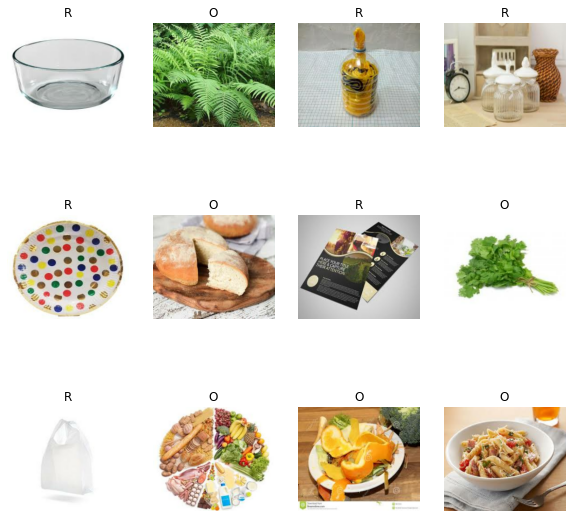

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

706

In [8]:
train_size = 0.8
len(dataset)*train_size

564.8000000000001

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

652

In [11]:
val_size=0.1
len(dataset)*val_size

70.60000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

646

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

564

In [17]:
len(val_ds)

70

In [18]:
len(test_ds)

72

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZEW, IMAGE_SIZEH),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZEW, IMAGE_SIZEH, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'), 
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 208, 242, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 206, 240, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 103, 120, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 101, 118, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (32, 99, 116, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (32, 97, 114, 64)         18496     
                                                      

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10
)

Epoch 1/10
564/564 [==============================] - 776s 1s/step - loss: 0.4663 - accuracy: 0.7957 - val_loss: 0.4508 - val_accuracy: 0.7897
Epoch 2/10
564/564 [==============================] - 707s 1s/step - loss: 0.4169 - accuracy: 0.8161 - val_loss: 0.3918 - val_accuracy: 0.8286
Epoch 3/10
564/564 [==============================] - 712s 1s/step - loss: 0.3859 - accuracy: 0.8314 - val_loss: 0.3864 - val_accuracy: 0.8348
Epoch 4/10
564/564 [==============================] - 726s 1s/step - loss: 0.3664 - accuracy: 0.8431 - val_loss: 0.3804 - val_accuracy: 0.8384
Epoch 5/10
564/564 [==============================] - 713s 1s/step - loss: 0.3571 - accuracy: 0.8482 - val_loss: 0.3591 - val_accuracy: 0.8487
Epoch 6/10
564/564 [==============================] - 509s 902ms/step - loss: 0.3519 - accuracy: 0.8529 - val_loss: 0.3594 - val_accuracy: 0.8487
Epoch 7/10
564/564 [==============================] - 527s 933ms/step - loss: 0.3527 - accuracy: 0.8519 - val_loss: 0.3754 - val_accuracy: 

In [27]:
scores = model.evaluate(test_ds)

72/72 [==============================] - 70s 275ms/step - loss: 0.3565 - accuracy: 0.8559


In [28]:
scores

[0.3565320670604706, 0.8559027910232544]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 564}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

10

In [34]:
history.history['loss'][:5]

[0.46625450253486633,
 0.41693955659866333,
 0.38593316078186035,
 0.3663732707500458,
 0.35708969831466675]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

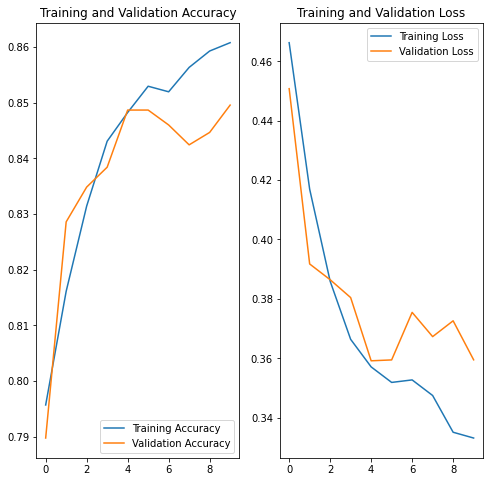

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: R
1/1 [==============================] - 0s 246ms/step
predicted label: O


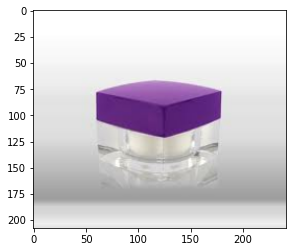

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


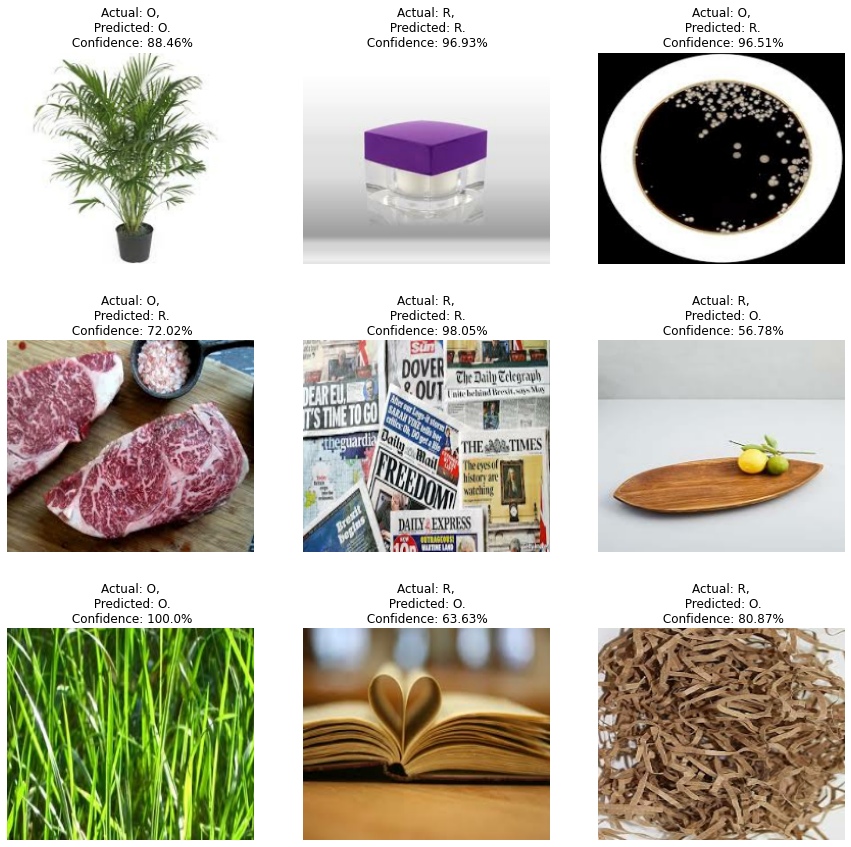

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [42]:
import os
model_version=max([int(i) for i in os.listdir("D:/Desktop/Waste_Management") + [0]])+1
model.save(f"D:/Desktop/Waste_Management/models/{model_version}")

ValueError: invalid literal for int() with base 10: '.git'

In [43]:
import os

# List all files and directories in the specified path
all_files = os.listdir("D:/Desktop/Waste_Management")

# Filter out non-integer file names and then convert to integers
numeric_files = [int(i) for i in all_files if i.isdigit()]

# If there are no numeric files, start with version 0; otherwise, use the maximum value + 1
model_version = max(numeric_files + [0]) + 1

# Save the model with the determined version number
model.save(f"D:/Desktop/Waste_Management/models/{model_version}")


INFO:tensorflow:Assets written to: D:/Desktop/Waste_Management/models/1\assets


INFO:tensorflow:Assets written to: D:/Desktop/Waste_Management/models/1\assets


In [44]:
model.save("D:/Desktop/Waste_Management/waste.h5")

In [48]:
pip install pickle

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [49]:
import pickle

In [51]:

pickle.dump(model,open('D:/Desktop/waste/file.pkl','wb'))








Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\sequential
......vars
...layers\sequential\layers\rescaling
......vars
...layers\sequential\layers\resizing
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........3
.........4
.........5
.........6
....

In [ ]:
from flask import Flask, render_template,request
import pickle
import numpy as np
from PIL import Image
from io import BytesIO
model = pickle.load(open('file.pkl','rb'))

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index1.html')

@app.route('/predict', methods=['POST'])
def result():
    print('0st if')
    file = request.files['image']
    print(file)
    # Check if the post request has the file part
    if 'image' not in request.files:
        print('1st if')
        return render_template('result.html', error='No file part')


    # If the user does not select a file, submit an empty part without filename
    if file.filename == '':
        print('2st if')
        return render_template('result.html', error='No selected file')

    # If the file exists and is allowed, read the content
    if file:
        try:
            print('3st if')
            # Read the image file
            img = Image.open(file)

            # Perform any necessary preprocessing (resize, normalize, etc.)
            # ...

            # Convert the image to a numpy array
            img_array = np.array(img)

            # Make predictions using the model
            pred = model.predict(img_array)
            print('prediction',pred)
            #return pred
            
            return render_template('result.html', data=pred)

        except Exception as e:
            return render_template('result.html', error=str(e))



if __name__ == "__main__":
    app.run(debug=True,use_reloader=False)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-11-27 19:51:16         5061
metadata.json                                  2023-11-27 19:51:16           64
variables.h5                                   2023-11-27 19:51:16    134982032
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\sequential
......vars
...layers\sequential\layers\rescaling
......vars
...layers\sequential\layers\resizing
......vars
...metrics\mean
......vars
.........0
.........1


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
INFO:werkzeug:127.0.0.1 - - [28/Nov/2023 12:15:55] "GET / HTTP/1.1" 500 -
Traceback (most recent call last):
  File "C:\Users\khair\anaconda3\Lib\site-packages\flask\app.py", line 2464, in __call__
    return self.wsgi_app(environ, start_response)
  File "C:\Users\khair\anaconda3\Lib\site-packages\flask\app.py", line 2450, in wsgi_app
    response = self.handle_exception(e)
  File "C:\Users\khair\anaconda3\Lib\site-packages\flask\app.py", line 1867, in handle_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\khair\anaconda3\Lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\khair\anaconda3\Lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\khair\anaconda3\Lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\khair\anaconda3\Li

In [18]:
!pip install numpy==1.26.2
!pip install opencv-python==4.8.1.78


  Using cached numpy-1.26.2-cp39-cp39-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.0
    Uninstalling numpy-1.20.0:
      Successfully uninstalled numpy-1.20.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.26.2 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.26.2 which is incompatible.


In [19]:
import cv2

cap = cv2.VideoCapture(0)
while True:
    success, img = cap.read()
    prediction = model.fit(img)
    prit(prediction) #class_name
    cv2.imshow("Result", img)
    cv2.waitKey(1)

TypeError: 'numpy._DTypeMeta' object is not subscriptable